- use latest version of joblib
- having a lot of null values for some reason

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import scikitplot.metrics as skplt
import joblib

In [25]:
# eng_train = pd.read_csv("lda_vecs_en.csv")
y = pd.read_csv("../Data/y_eng_oversampled.csv", header=None, names=["Y"])
bow = pd.read_csv('../Cache/Embeddings/bow.csv')
# le = LabelEncoder()
# whole_data['Y'] = le.fit_transform(whole_data["Sub-task A"])
# whole_data.dropna(axis=0, subset=["monolingual"], inplace=True)
X_train, X_test, Y_train, Y_test = train_test_split(bow, y, random_state = 0, test_size = 0.3)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape
# bow.shape, y.shape

((8843, 65), (8843, 1), (3790, 65), (3790, 1))

In [3]:
bow_vec = joblib.load('../Cache/Embeddings/bow.csv')

/home/rachit/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
X_train_tweets = bow_vec.transform(X_train)
X_train_text_df = pd.DataFrame(X_train_tweets.todense(), columns=[x+'_text' for x in bow_vec.get_feature_names()])
X_train_text_df.shape

(3678, 40)

In [6]:
X_test_tweets = bow_vec.transform(X_test)
X_test_text_df = pd.DataFrame(X_test_tweets.todense(), columns=[x+'_text' for x in bow_vec.get_feature_names()])
X_test_text_df.shape

(1262, 54)

In [27]:
def run_the_mn_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'mnb1':
        
        mn_params = {
            'fit_prior': [True],
            'alpha': [0, 0.5, 1]}
        
        M = GridSearchCV(MultinomialNB(),
                        mn_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'mnb2':
        
         mn_params = {
            'fit_prior': [False],
            'alpha': [0, 0.5, 1]}
        
         M = GridSearchCV(MultinomialNB(),
                        mn_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print('There is an error.')
        
    M.fit(X_train_text_df.values, y_train)
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
    
#     #skplt.plot_roc_curve(predictions,y_test)
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    4.3s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.5s finished
/home/rachit/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/rachit/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Train score = 0.606694560669456
Test score = 0.6068601583113457
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'alpha': 0, 'fit_prior': True}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

         CAG       0.60      0.43      0.50      1290
         NAG       0.57      0.81      0.67      1254
         OAG       0.67      0.59      0.63      1246

    accuracy                           0.61      3790
   macro avg       0.61      0.61      0.60      3790
weighted avg       0.61      0.61      0.60      3790



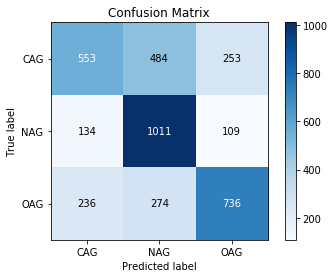

In [28]:
run_the_mn_models("mnb1", X_train, X_test, Y_train, Y_test)

In [29]:
def run_the_lr_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    
    if model == 'lr1':
        
        lr_1_params = {
            'penalty': ['l1'],
            'C': [1, 1.5, 2, 2.5],
            'class_weight': ['balanced'],
            'warm_start': [True, False],
            'random_state': [42],
            'solver': ['liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_1_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'lr2':
        
        lr_2_params = {
            'penalty': ['l2'],
            'C': [1, 1.5, 2, 2.5],
            'class_weight': ['balanced'],
            'warm_start': [True, False],            
            'random_state': [42],
            'solver': ['lbfgs', 'liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_2_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)

    else:
        print('There is an error.')
        
    M.fit(X_train_text_df.values, y_train)
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
    
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))
    
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.0s finished
/home/rachit/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Train score = 0.6320253307701006
Test score = 0.6221635883905013
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 2.5, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'warm_start': True}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

         CAG       0.64      0.44      0.53      1290
         NAG       0.57      0.80      0.67      1254
         OAG       0.68      0.63      0.66      1246

    accuracy                           0.62      3790
   macro avg       0.63      0.62      0.62      3790
weighted avg       0.63      0.62      0.61      3790



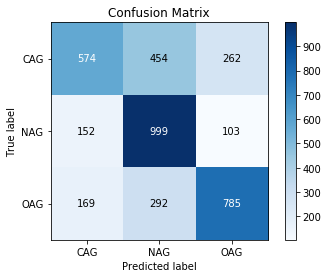

In [30]:
run_the_lr_models("lr2", X_train, X_test, Y_train, Y_test)

In [31]:
def run_the_sv_models(model, X_train, X_test, Y_tr, Y_te):   
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'sv1':
        
        sv_params = {
            'kernel': ['rbf'], 
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000] }
        
        M = GridSearchCV(SVC(probability=True),
                        sv_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'sv2':
        
        
        sv_params = {
            'kernel': ['rbf'], 
            'gamma': [0.01, 1, 10, 100],
            'C': [1, 10, 100, 1000] }

        M = GridSearchCV(SVC(probability=True),
                        sv_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print("Invalid Model!")
        
    M.fit(X_train_text_df.values, y_train)
      
    #save in pickle file
    joblib.dump(M, "SVM_TFIDF.pkl")
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 15.7min finished
/home/rachit/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Train score = 0.7663688793395906
Test score = 0.7680738786279684
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

         CAG       0.86      0.65      0.74      1290
         NAG       0.65      0.88      0.75      1254
         OAG       0.86      0.78      0.82      1246

    accuracy                           0.77      3790
   macro avg       0.79      0.77      0.77      3790
weighted avg       0.79      0.77      0.77      3790



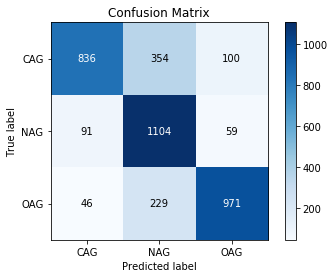

In [33]:
run_the_sv_models("sv2", X_train, X_test, Y_train, Y_test)

In [35]:
x=pd.read_csv("../Data/x_eng_oversampled.csv")

In [36]:
x

,monolingual,Sub-task B
0,next part,1
1,iii8mllllllm mdxfvb8o90lplppi0005,1
2,osm vedio upmake vedios,1
3,what fuck respect shwetabh watching videos lon...,1
4,concerned authorities bring arundathi roy type...,1
5,famous care die hateful talks,1
6,best topic law students,1
7,even unaware preeti son ready accept other's b...,1
8,she,1
9,6001733614,1
